In [1]:
# clone the ADIS repository
!git clone https://github.com/sathishkumar67/SSD_MobileNetV3_ADIS.git
# move the files to the current directory
!mv /kaggle/working/SSD_MobileNetV3_ADIS/* /kaggle/working/
# upgrade pip
!pip install --upgrade pip
# install the required packages
!pip install  -r requirements.txt --upgrade --upgrade-strategy eager

Cloning into 'SSD_MobileNetV3_ADIS'...
remote: Enumerating objects: 371, done.
remote: Counting objects: 100% (1/1), done.
remote: Enumerating objects: 371, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 371 (delta 0), reused 0 (delta 0), pack-reused 370 (from 1)
Receiving objects: 100% (371/371), 149.16 MiB | 41.25 MiB/s, done.
Resolving deltas: 100% (224/224), done.
remote: Total 371 (delta 0), reused 0 (delta 0), pack-reused 370 (from 1)
Receiving objects: 100% (371/371), 149.16 MiB | 41.25 MiB/s, done.
Resolving deltas: 100% (224/224), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.4 MB/s eta 0:00:0000:01
  Attempting uninstall: pip
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
      Successfully unin

In [2]:
# necessary imports
from typing import List
import os
import optuna
import joblib
from tqdm import tqdm
import random
import numpy as np
from tqdm import tqdm
from huggingface_hub import hf_hub_download
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from ssdlite_mobnetv3_adis.utils import unzip_file, replace_activation_function
from ssdlite_mobnetv3_adis.dataset import collate_fn, SSDLITEOBJDET_DATASET, CachedSSDLITEOBJDET_DATASET
from ssdlite_mobnetv3_adis.model import SSDLITE_MOBILENET_V3_Large
from ssdlite_mobnetv3_adis.epu import EPU
from ssdlite_mobnetv3_adis.trainer import bohb_tunner, train

# set random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# set constants
REPO_ID = "pt-sk/ADIS" 
DATASET_NAME = "balanced_dataset"
REPO_TYPE = "dataset"
FILENAME_IN_REPO = f"{DATASET_NAME}.zip"
LOCAL_DIR = os.getcwd()
DATASET_PATH = f"{LOCAL_DIR}/{FILENAME_IN_REPO}"
DATASET_FOLDER_PATH = f"{LOCAL_DIR}/{DATASET_NAME}"                       
CLASSES = ['Cat', 'Cattle', 'Chicken', 'Deer', 'Dog', 'Squirrel', 'Eagle', 'Goat', 'Rodents', 'Snake'] 
NUM_CLASSES = len(CLASSES)
NUM_CLASSES_WITH_BG = NUM_CLASSES + 1    # 1 for background class

# download the dataset and unzip it
hf_hub_download(repo_id=REPO_ID, filename=FILENAME_IN_REPO, repo_type=REPO_TYPE, local_dir=LOCAL_DIR)
unzip_file(DATASET_PATH, LOCAL_DIR)

balanced_dataset.zip:   0%|          | 0.00/7.04G [00:00<?, ?B/s]

Unzipping: 100%|██████████| 7.07G/7.07G [00:41<00:00, 168MB/s]



Unzipped /kaggle/working/balanced_dataset.zip to /kaggle/working
Removed zip file: /kaggle/working/balanced_dataset.zip
Removed zip file: /kaggle/working/balanced_dataset.zip


In [4]:
# set pin memory device
PIN_MEMORY_DEVICE = "cuda:0"
NUM_CORES = os.cpu_count()
BATCH_SIZE = 64

# prepare the dataset
train_dataset = CachedSSDLITEOBJDET_DATASET(
    dataset_class=SSDLITEOBJDET_DATASET,
    root_dir=DATASET_FOLDER_PATH,
    split="train",
    num_classes=NUM_CLASSES_WITH_BG)

val_dataset = CachedSSDLITEOBJDET_DATASET(
    dataset_class=SSDLITEOBJDET_DATASET,
    root_dir=DATASET_FOLDER_PATH,
    split="val",
    num_classes=NUM_CLASSES_WITH_BG)

test_dataset = CachedSSDLITEOBJDET_DATASET(
    dataset_class=SSDLITEOBJDET_DATASET,
    root_dir=DATASET_FOLDER_PATH,
    split="test",
    num_classes=NUM_CLASSES_WITH_BG)


# samplers for reproducibility
train_sampler = RandomSampler(train_dataset, generator=torch.Generator().manual_seed(RANDOM_SEED))
val_sampler = RandomSampler(val_dataset, generator=torch.Generator().manual_seed(RANDOM_SEED))
test_sampler = RandomSampler(test_dataset, generator=torch.Generator().manual_seed(RANDOM_SEED))


# prepare the dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    num_workers=NUM_CORES,
    collate_fn=collate_fn,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
    pin_memory_device=PIN_MEMORY_DEVICE)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    sampler=val_sampler,
    num_workers=NUM_CORES,
    collate_fn=collate_fn,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
    pin_memory_device=PIN_MEMORY_DEVICE)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    sampler=test_sampler,
    num_workers=NUM_CORES,
    collate_fn=collate_fn,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
    pin_memory_device=PIN_MEMORY_DEVICE)

Preprocessing dataset and caching to /kaggle/working/balanced_dataset/train_cache...


100%|██████████| 18139/18139 [03:42<00:00, 81.34it/s] 



Preprocessing dataset and caching to /kaggle/working/balanced_dataset/val_cache...


100%|██████████| 2390/2390 [00:25<00:00, 92.03it/s] 


Preprocessing dataset and caching to /kaggle/working/balanced_dataset/test_cache...


 74%|███████▎  | 1757/2390 [00:20<00:08, 78.71it/s] libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
100%|██████████| 2390/2390 [00:27<00:00, 86.36it/s] 


In [5]:
custom_ckpt = torch.load("/kaggle/working/ckpt/ssdlite_mobv3_custom_params_ckpt.pth", map_location="cpu")
best_ckpt = torch.load("/kaggle/working/ckpt/ssdlite_mobnetv3_bestparams_ckpt.pth", map_location="cpu")

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_model = SSDLITE_MOBILENET_V3_Large(num_classes_with_bg=NUM_CLASSES_WITH_BG)
custom_model.load_state_dict(custom_ckpt['model_state_dict'], strict=True)
custom_model.to(device)
custom_model.eval()

best_model = SSDLITE_MOBILENET_V3_Large(num_classes_with_bg=NUM_CLASSES_WITH_BG)
best_model.load_state_dict(best_ckpt['model_state_dict'], strict=True)
best_model.to(device)
best_model.eval()

print("Model loaded successfully!")

Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /root/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth
100%|██████████| 13.4M/13.4M [00:02<00:00, 4.97MB/s]
100%|██████████| 13.4M/13.4M [00:02<00:00, 4.97MB/s]


Model loaded successfully!


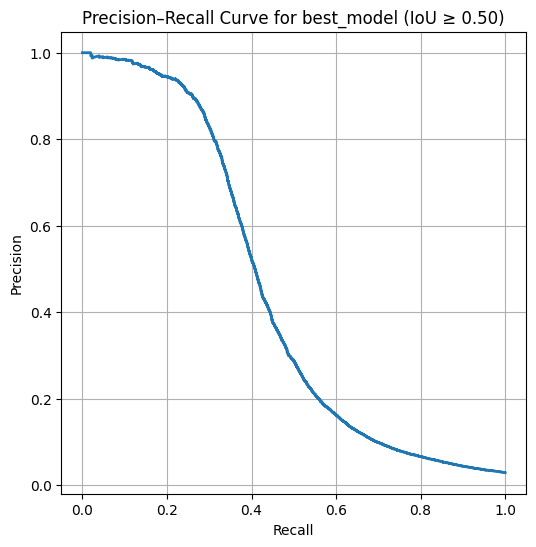

In [7]:
# plot precision-recall curve for custom model
from sklearn.metrics import precision_recall_curve
from torchvision.ops import box_iou
import matplotlib.pyplot as plt

all_scores_best = []
all_true_best = []

IOU_THRESHOLD = 0.5

with torch.no_grad():
    for images, targets in val_loader:
        outputs = best_model(images.to(device))
        for out, tgt in zip(outputs, targets):
            gt_boxes  = tgt["boxes"].cuda()
            gt_labels = tgt["labels"].cuda()
            pred_boxes  = out["boxes"]
            pred_scores = out["scores"]
            pred_labels = out["labels"]
            if pred_boxes.numel() == 0:
                continue
            ious = box_iou(pred_boxes.cuda(), gt_boxes)
            for idx in range(pred_boxes.size(0)):
                score = pred_scores[idx].item()
                label = pred_labels[idx].item()
                mask = (gt_labels == label)
                if mask.sum() > 0:
                    iou_vals = ious[idx, mask]
                    max_iou = iou_vals.max().item()
                    is_tp = 1 if max_iou >= IOU_THRESHOLD else 0
                else:
                    is_tp = 0
                all_scores_best.append(score)
                all_true_best.append(is_tp)

precision_best, recall_best, thresholds_best = precision_recall_curve(all_true_best, all_scores_best)

plt.figure(figsize=(6,6))
plt.plot(recall_best, precision_best, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve for best_model (IoU ≥ %.2f)" % IOU_THRESHOLD)
plt.grid(True)
plt.show()

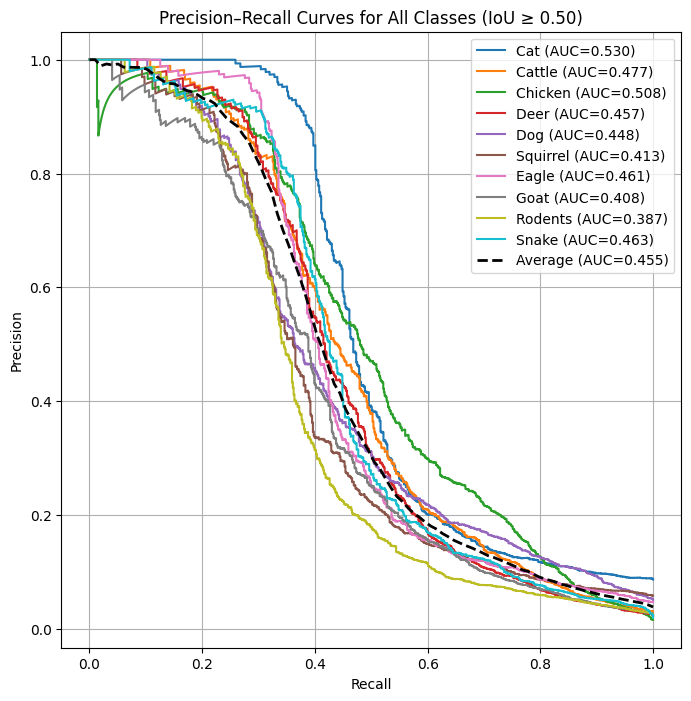

In [8]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

num_classes = len(CLASSES)
class_scores = [[] for _ in range(num_classes)]
class_true = [[] for _ in range(num_classes)]

IOU_THRESHOLD = 0.5

with torch.no_grad():
    for images, targets in val_loader:
        outputs = best_model(images.to(device))
        for out, tgt in zip(outputs, targets):
            gt_boxes  = tgt["boxes"].cuda()
            gt_labels = tgt["labels"].cuda()
            pred_boxes  = out["boxes"]
            pred_scores = out["scores"]
            pred_labels = out["labels"]
            if pred_boxes.numel() == 0:
                continue
            ious = box_iou(pred_boxes.cuda(), gt_boxes)
            for idx in range(pred_boxes.size(0)):
                score = pred_scores[idx].item()
                label = pred_labels[idx].item()
                mask = (gt_labels == label)
                if mask.sum() > 0:
                    iou_vals = ious[idx, mask]
                    max_iou = iou_vals.max().item()
                    is_tp = 1 if max_iou >= IOU_THRESHOLD else 0
                else:
                    is_tp = 0
                if label > 0 and label <= num_classes:
                    class_scores[label-1].append(score)
                    class_true[label-1].append(is_tp)

plt.figure(figsize=(8,8))
mean_precisions = []
mean_recalls = []
mean_aucs = []

for i, cls in enumerate(CLASSES):
    if len(class_true[i]) == 0 or len(set(class_true[i])) < 2:
        continue  # skip if no data or only one class present
    precision, recall, _ = precision_recall_curve(class_true[i], class_scores[i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{cls} (AUC={pr_auc:.3f})')
    mean_precisions.append(np.interp(np.linspace(0,1,100), recall[::-1], precision[::-1]))
    mean_recalls.append(np.linspace(0,1,100))
    mean_aucs.append(pr_auc)

# Average PR curve
if mean_precisions:
    avg_precision = np.mean(mean_precisions, axis=0)
    avg_recall = mean_recalls[0]
    avg_auc = auc(avg_recall, avg_precision)
    plt.plot(avg_recall, avg_precision, 'k--', linewidth=2, label=f'Average (AUC={avg_auc:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curves for All Classes (IoU ≥ %.2f)' % IOU_THRESHOLD)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# calculate per-class metrics  

# from typing import Tuple
# import pandas as pd
# from torchvision.ops import box_iou
# from collections import defaultdict
# from torchmetrics.detection import MeanAveragePrecision


# def evaluate_model(model, dataloader, device, iou_threshold=None):
#     metric = MeanAveragePrecision(
#         box_format='xyxy',
#         iou_type='bbox',
#         iou_thresholds=[0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95],
#         class_metrics=True,
#         extended_summary=True
#     )
    
#     model.eval()
#     with torch.no_grad():
#         for images, targets in dataloader:
#             # Move images to the device
#             outputs = model(images.to(device))
            
#             # Convert outputs to TorchMetrics format
#             preds = []
#             for i, output in enumerate(outputs):
#                 preds.append({
#                     'boxes': output['boxes'].cpu(),
#                     'scores': output['scores'].cpu(),
#                     'labels': output['labels'].cpu()
#                 })
            
#             # Convert targets to TorchMetrics format
#             targs = []
#             for target in targets:
#                 targs.append({
#                     'boxes': target['boxes'].cpu(),
#                     'labels': target['labels'].cpu()
#                 })
            
#             metric.update(preds, targs)
    
#     # Compute metrics
#     results = metric.compute()
#     return results


# def calculate_per_class_with_iou(model, dataloader, device, classes,
#                                 conf_thresh=0.2, iou_thresh=0.5):
#     counters  = defaultdict(lambda: {"tp":0,"fp":0,"fn":0,"support":0})
#     iou_sums   = defaultdict(float)
#     iou_counts = defaultdict(int)

#     model.eval()
#     with torch.no_grad():
#         for images, targets in dataloader:
#             outputs = model([img.to(device) for img in images])
#             for output, target in zip(outputs, targets):
#                 # Prepare tensors
#                 pred_boxes  = output["boxes"].cpu()
#                 pred_scores = output["scores"].cpu()
#                 pred_labels = output["labels"].cpu()
#                 true_boxes  = target["boxes"]
#                 true_labels = target["labels"]

#                 # Filter by confidence
#                 keep = pred_scores > conf_thresh
#                 pred_boxes  = pred_boxes[keep]
#                 pred_labels = pred_labels[keep]

#                 # Count support
#                 for lbl in true_labels.tolist():
#                     counters[lbl]["support"] += 1

#                 # No predictions → all GT are FN
#                 if pred_boxes.numel() == 0:
#                     for lbl in true_labels.tolist():
#                         counters[lbl]["fn"] += 1
#                     continue

#                 # Compute IoU matrix and find matches
#                 iou_matrix = box_iou(pred_boxes, true_boxes)
#                 matches    = torch.nonzero(iou_matrix > iou_thresh, as_tuple=False)

#                 matched_pred, matched_true = set(), set()
#                 for pi, ti in matches.tolist():
#                     matched_pred.add(pi); matched_true.add(ti)
#                     p_lbl = int(pred_labels[pi].item())
#                     t_lbl = int(true_labels[ti].item())

#                     if p_lbl == t_lbl:
#                         counters[p_lbl]["tp"] += 1
#                         iou_sums[p_lbl]   += iou_matrix[pi, ti].item()
#                         iou_counts[p_lbl] += 1
#                     else:
#                         counters[p_lbl]["fp"] += 1
#                         counters[t_lbl]["fn"] += 1

#                 # Unmatched → FP or FN
#                 for pi in range(len(pred_boxes)):
#                     if pi not in matched_pred:
#                         cls = int(pred_labels[pi].item())
#                         counters[cls]["fp"] += 1
#                 for ti in range(len(true_boxes)):
#                     if ti not in matched_true:
#                         cls = int(true_labels[ti].item())
#                         counters[cls]["fn"] += 1

#     # Build results
#     results = {}
#     for cls, cnt in counters.items():
#         tp, fp, fn, sup = cnt["tp"], cnt["fp"], cnt["fn"], cnt["support"]
#         prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
#         rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
#         f1   = 2*prec*rec/(prec+rec) if (prec+rec) > 0 else 0.0
#         avg_iou = iou_sums[cls]/iou_counts[cls] if iou_counts[cls]>0 else 0.0
#         accuracy = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0
        
#         # Store results
#         results[cls] = {
#             "count": sup,
#             "precision": prec,
#             "recall":    rec,
#             "f1_score":  f1,
#             "accuracy":  accuracy,
#             "avg_iou":   avg_iou
#         }
        
#     # Convert to DataFrame for better readability
#     df_metrics = pd.DataFrame(results).T
#     df_metrics.index = [classes[idx-1] for idx in df_metrics.index]
#     df_metrics = df_metrics.sort_index()
#     df_metrics["mAP@50"] = evaluate_model(model, dataloader, device)["map_50"].cpu().tolist()
#     df_metrics["mAP@[50:95]"] = evaluate_model(model, dataloader, device)["map"].cpu().tolist()
#     return df_metrics

In [19]:
# import time
# start_time = time.time()
# df_metrics = calculate_per_class_with_iou(custom_model, train_loader, device, classes=CLASSES)
# df_metrics.loc["Average"] = df_metrics.mean()
# print(f"Per-class metrics for test set:\n{df_metrics}")
# end_time = time.time()
# print(f"Time taken for test set evaluation: {end_time - start_time:.2f} seconds")

In [ ]:
# import time
# start_time = time.time()
# df_metrics = calculate_per_class_with_iou(best_model, train_loader, device, classes=CLASSES)
# df_metrics.loc["Average"] = df_metrics.mean()
# print(f"Per-class metrics for test set:\n{df_metrics}")
# end_time = time.time()
# print(f"Time taken for test set evaluation: {end_time - start_time:.2f} seconds") 